## Exploratory Analysis

In [6]:
from pathlib import Path
import csv
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools
import json
import os.path
from sklearn.preprocessing import StandardScaler

pd.options.display.float_format = '{:.2f}'.format

In [7]:
def param_default():
    return {
        'datasets' : {
            'SG_BD' : 'code_completion_random_cut_5k_30_512_tokens', 
            'DC_SG_BD' : 'code_completion_docstring_random_cut_3.8k_30_150_tokens', 
            'DC_SG' : 'code_completion_docstring_signature_3.8k_30_150_tokens', 
            'DC': 'code_completion_docstring_5k_30_150_tokens'
        },
        'rational_results': '/workspaces/code-rationales/data/rationales/gpt',
        'sampling_results': '/workspaces/code-rationales/data/sampling/gpt',
        'tagged_rationales': '/workspaces/code-rationales/data/tagged_rationales',
        'global_ast_results': '/workspaces/code-rationales/data/global_ast_results/gpt',
        'distributions_results' : '/workspaces/code-rationales/data/rationales_distribution_results/gpt',
        'num_experiments': 30,
        'num_samples': 100,
    }
    
params = param_default()

### Proportionality of NL

In [5]:
### Retrieve experiments
def retrieve_df_tagged_rationales(dataset_name):
    get_experiment_path =  lambda exp: params['tagged_rationales'] + '/' + dataset_name +'_exp_' + str(exp) +'.csv'
    experiment_paths = [get_experiment_path(exp) for exp in range(params['num_experiments'])]
    df_tagged_exp_rationales = []
    for experiment_path in experiment_paths:
        df_tagged_exp_rationales.append(pd.read_csv(experiment_path, index_col=0))
    return df_tagged_exp_rationales

In [6]:
### token types by sample
def get_sample_types_distribution(df_tagged_tokens):
    nl_tokens_count = 0 
    sc_tokens_count = 0
    for token_tags in df_tagged_tokens['tags']:
        nl_tokens_count += sum(1 for tag in eval(token_tags) if tag[0] == 'nl')
        sc_tokens_count+= sum(1 for tag in eval(token_tags) if tag[0] == 'sc')
    return nl_tokens_count, sc_tokens_count

In [7]:
## token type distributions by experiment
def get_experiment_token_type_counts(df_exp, df_sampled_inputs):
    exp_prompt_nl_tokens_count = []
    exp_prompt_sc_tokens_count = []
    exp_generated_nl_tokens_count = []
    exp_generated_sc_tokens_count = []
    for sample_id in range(0, params['num_samples']):
        df_prompt_rationales = df_exp.loc[df_exp['from_seq_id']==sample_id].head(len(eval(df_sampled_inputs['input_ids'][sample_id])))
        df_generated_rationales = df_exp.loc[df_exp['from_seq_id']==sample_id].iloc[len(eval(df_sampled_inputs['input_ids'][sample_id])):]
        prompt_nl_tokens_count, prompt_sc_tokens_count = get_sample_types_distribution(df_prompt_rationales)
        generated_nl_tokens_count, generated_sc_tokens_count = get_sample_types_distribution(df_generated_rationales)
        exp_prompt_nl_tokens_count.append(prompt_nl_tokens_count)
        exp_prompt_sc_tokens_count.append(prompt_sc_tokens_count)
        exp_generated_nl_tokens_count.append(generated_nl_tokens_count)
        exp_generated_sc_tokens_count.append(generated_sc_tokens_count)
    return np.median(exp_prompt_nl_tokens_count), np.median(exp_prompt_sc_tokens_count), np.median(exp_generated_nl_tokens_count), np.median(exp_generated_sc_tokens_count)

In [8]:
def get_token_type_counts(df_exp_tagged_rationales, df_sampled_inputs):
    prompt_nl_tokens_count = []
    prompt_sc_tokens_count = []
    generated_nl_tokens_count = []
    generated_sc_tokens_count = []
    for experiment in df_exp_tagged_rationales:
        exp_prompt_nl_tokens, exp_prompt_sc_tokens, exp_generated_nl_tokens, exp_generated_sc_tokens = get_experiment_token_type_counts(experiment, df_sampled_inputs)
        prompt_nl_tokens_count.append(exp_prompt_nl_tokens), prompt_sc_tokens_count.append(exp_prompt_sc_tokens), generated_nl_tokens_count.append(exp_generated_nl_tokens), generated_sc_tokens_count.append(exp_generated_sc_tokens)
    return np.median(prompt_nl_tokens_count), np.median(prompt_sc_tokens_count), np.median(generated_nl_tokens_count), np.median(generated_sc_tokens_count)

In [ ]:
df_token_types = pd.DataFrame(columns=['dataset', 'token_type', 'count'])
for dataset_id, dataset in params['datasets'].items():
    df_sampled_inputs = pd.read_csv( param_default()['sampling_results'] + '/' + dataset +'.csv', index_col=0)
    df_exp_tagged_rationales = retrieve_df_tagged_rationales(dataset)
    prompt_nl_tokens_count, prompt_sc_tokens_count, generated_nl_tokens_count, generated_sc_tokens_count = get_token_type_counts(df_exp_tagged_rationales, df_sampled_inputs)
    df_token_types = df_token_types.append({'dataset': dataset_id, 'token_type': 'PMT_NL', 'count': prompt_nl_tokens_count}, ignore_index=True)
    df_token_types = df_token_types.append({'dataset': dataset_id, 'token_type': 'PMT_SC', 'count': prompt_sc_tokens_count}, ignore_index=True)
    df_token_types = df_token_types.append({'dataset': dataset_id, 'token_type': 'GEN_NL', 'count': generated_nl_tokens_count}, ignore_index=True)
    df_token_types = df_token_types.append({'dataset': dataset_id, 'token_type': 'GEN_SC', 'count': generated_sc_tokens_count}, ignore_index=True)

In [ ]:
df_token_types

,dataset,token_type,count
0,SG_BD,PMT_NL,9.50
1,SG_BD,PMT_SC,92.50
2,SG_BD,GEN_NL,12.00
3,SG_BD,GEN_SC,125.25
4,DC_SG_BD,PMT_NL,39.00
5,DC_SG_BD,PMT_SC,182.50
6,DC_SG_BD,GEN_NL,41.50
7,DC_SG_BD,GEN_SC,476.25
8,DC_SG,PMT_NL,28.50
9,DC_SG,PMT_SC,39.00


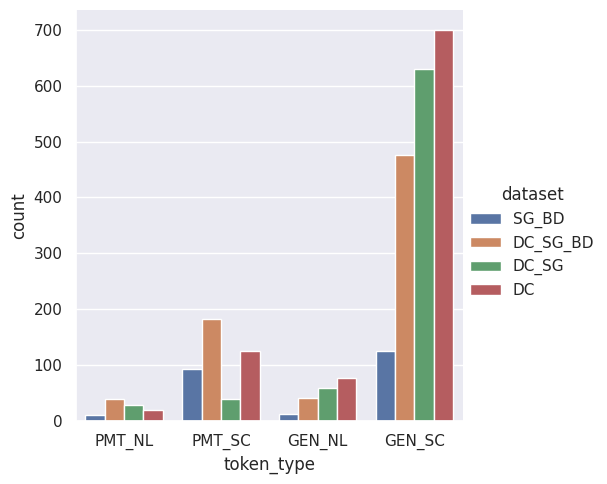

In [ ]:
g = sns.catplot(x='token_type', y='count', hue='dataset', data=df_token_types, kind='bar', height=5, aspect=1)

### Distribution of probabilities

In [8]:
get_experiment_path =  lambda results_folder, dataset, exp: results_folder + '/' + dataset + '_exp_' + str(exp) +'.txt'

In [9]:
def load_ast_rationales_results(dataset_id: str) :
    experiment_paths = [get_experiment_path(params['global_ast_results'], params['datasets'][dataset_id], exp) for exp in range(params['num_experiments'])]
    experiment_results = []
    for experiment_path in experiment_paths:
        with open(experiment_path, 'r') as file:
            experiment_results.append(json.loads(file.read()))
    return experiment_results

In [10]:
def flat_rationales_probabilities(rationales_results):
    dataset_rationales_values = []
    for experiment_result in rationales_results:
        for target_key, target_values in experiment_result.items():
            for rational_key, rational_values in target_values.items():
                #dataset_rationales_values = dataset_rationales_values + [round(rational_prob, 3) for rational_prob in rational_values]
                dataset_rationales_values = dataset_rationales_values + rational_values
    return dataset_rationales_values

In [11]:
def get_rationales_distribution(dataset_id: str, experiments: int):
    file_path = params['distributions_results'] + '/' + params['datasets'][dataset_id] + '_' + 'dist' + '.json'
    #if os.path.isfile(file_path):
    #    with open(file_path, 'r') as output_file:
    #        return json.load(output_file)
    ast_rationales_results = load_ast_rationales_results(dataset_id)[:experiments]
    dataset_rationales_values = flat_rationales_probabilities(ast_rationales_results)
    #with open(file_path, 'w') as output_file: 
    #    json.dump(dataset_rationales_values, output_file)
    #    print('done')
    return dataset_rationales_values

In [22]:
def create_df_rationales_distributions(): 
    rationales_distributions = {key: [] for key in params['datasets'].keys()}
    for dataset_id in params['datasets'].keys():
        rationales_distributions[dataset_id] = get_rationales_distribution(dataset_id, 1)
    group = []
    for dataset_id, distribution in rationales_distributions.items():
        group += [dataset_id]*len(distribution)
    plot_data = {
        'Values': np.concatenate(list(rationales_distributions.values())),
        'Dataset': group
    } 
    return pd.DataFrame(plot_data)


In [23]:
df_rationales_distributions = create_df_rationales_distributions()

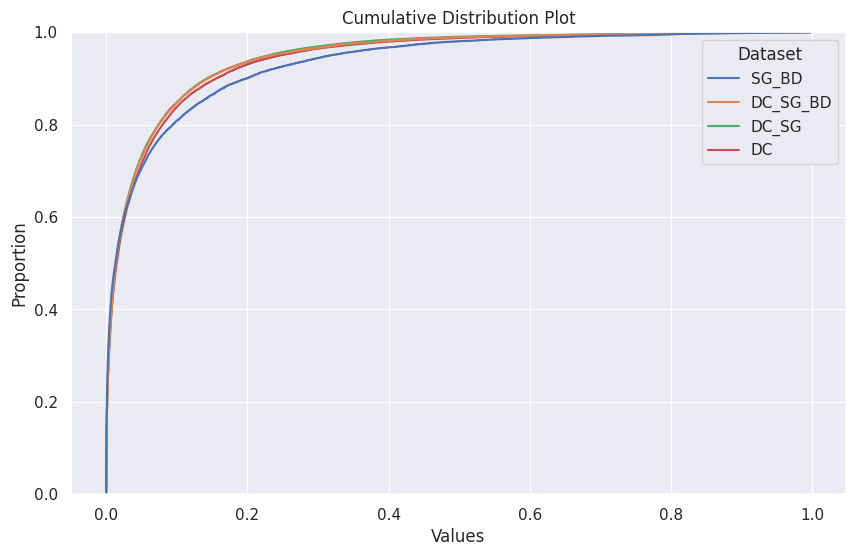

In [38]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df_rationales_distributions, x='Values', hue='Dataset', stat='proportion')
plt.title('Cumulative Distribution Plot')
plt.show()

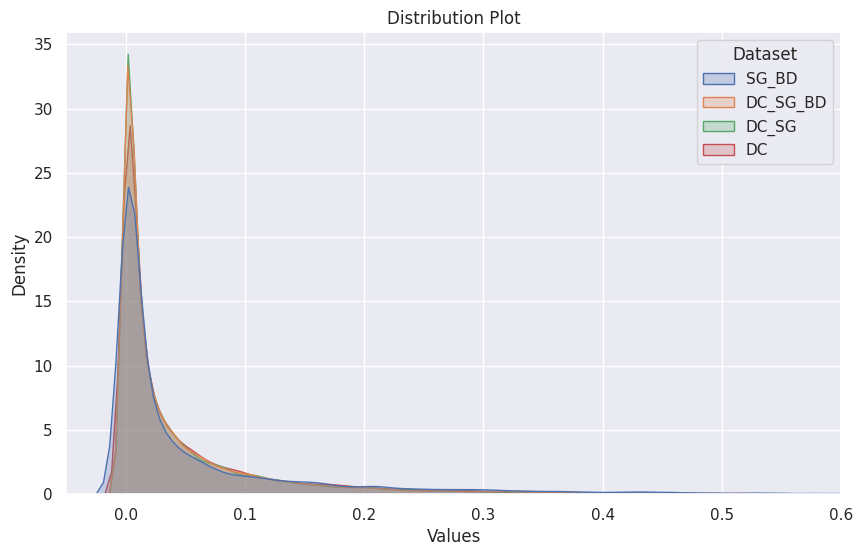

In [42]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_rationales_distributions, x='Values', hue='Dataset', common_norm=False, fill=True)
plt.title('Distribution Plot')
plt.xlim(-0.05,0.6)
plt.show()

In [55]:
pd.set_option('display.float_format', lambda x: '%7f' % x)
df_rationales_distributions[df_rationales_distributions['Dataset'] == 'DC'].describe()

,Values
count,2373368.000000
mean,0.055830
std,0.106637
min,0.000000
25%,0.002326
50%,0.014836
75%,0.060037
max,0.996612
